Import libraries

In [85]:
import time
import random
import string
import pandas as pd
import numpy as np
import sys
import re
import os
import os.path
from re import search
from datetime import datetime
from os import walk
from matplotlib import pyplot as plt
import numpy as np
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline
from kmodes.util.dissim import matching_dissim, ng_dissim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## 1. Datasets

### 1.1. Masterlist

#### 1.1.1. Read in tables

In [2]:
masterlist = pd.read_parquet('/Users/z0176164/Library/CloudStorage/OneDrive-ZFFriedrichshafenAG/Master thesis/masterlist.parquet')

#### 1.1.2. Data transformations

Use the first three characters of the Artnr as a column

In [3]:
masterlist["Artnr First 3"] = masterlist['artnr'].str[0:3]
masterlist = masterlist.drop(columns=['nettogewicht_kg','laenge_mm','breite_mm','hoehe_mm','volumen_l']) # For now we get rid of the numeric columns
masterlist.head(5)

,brand,artnr,genart_bez_en,vehicle_type,pmva,Artnr First 3
0,TRW,BHT266E,Brake Caliper,PC,T001,BHT
1,SACHS,3000 830 301,Clutch Kit,"Bus, PC, Truck",0100,300
2,WABCO,4630903110,Air Suspension Valve,None,0100,463
3,TRW,JGT4336S,Shock Absorber,None,T008,JGT
4,GIRLING,90042097,Brake Hose,PC,T001,900


Rename some columns

In [4]:
masterlist_renamed = masterlist.rename(columns={'genart_bez_en':'Genart description',
                           'vehicle_type':'Vehicle Type',
                           'pmva':'PMVA',
                           'brand':'Brand',
                           'artnr':'Artnr'})

Convert the column vehicle type into dummy variables

In [5]:
# Define a function to create dummy columns
def create_dummy_columns(df):
    # Extract the original columns
    original_columns = df.columns.tolist()
    original_columns.remove('Vehicle Type')  # Exclude 'Vehicle Type' from original columns
    
    # Create a set to store all unique values in the series
    unique_values = set()
    
    # Iterate over each row to extract unique values
    for value in df['Vehicle Type']:
        if value is not None:
            unique_values.update(value.split(', '))
    
    # Create dummy columns for each unique value
    dummy_columns = {}
    for value in unique_values:
        dummy_columns[value] = df['Vehicle Type'].apply(lambda x: 1 if (x is not None and value in x.split(', ')) else 0)
    
    # Combine dummy columns with original columns
    df = pd.concat([df, pd.DataFrame(dummy_columns)], axis=1)
    
    # Drop the 'Vehicle Type' column
    df.drop(columns=['Vehicle Type'], inplace=True)
    
    return df

# Call the function to create dummy columns
masterlist_with_dummies = create_dummy_columns(masterlist_renamed)

masterlist = masterlist_with_dummies[["Artnr","Artnr First 3","Brand","Genart description","PMVA",
                        "Axle","Truck","Tractor","PC","Bus"]]

masterlist.head(5)

,Artnr,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
0,BHT266E,BHT,TRW,Brake Caliper,T001,0,0,0,1,0
1,3000 830 301,300,SACHS,Clutch Kit,0100,0,1,0,1,1
2,4630903110,463,WABCO,Air Suspension Valve,0100,0,0,0,0,0
3,JGT4336S,JGT,TRW,Shock Absorber,T008,0,0,0,0,0
4,90042097,900,GIRLING,Brake Hose,T001,0,0,0,1,0


Number of articles

In [6]:
masterlist_art = masterlist["Artnr"].drop_duplicates()
print("The total number or different articles are:")
print(masterlist_art.shape[0])

The total number or different articles are:
300318


Get rid of the Artnr column

In [7]:
masterlist = masterlist.drop('Artnr', axis=1)

#### 1.1.3. Exploratory data analysis

Shape dataset

In [8]:
print("The shape of the dataset is the following:")
print(masterlist_with_dummies.shape)

The shape of the dataset is the following:
(303515, 10)


Basic statistics

In [9]:
# Frequency count for categorical columns
categorical_counts = {}
for col in masterlist_with_dummies.columns[0:4]:
    categorical_counts[col] = masterlist_with_dummies[col].value_counts()
    
print("\nFrequency count for categorical columns:")
for col, counts in categorical_counts.items():
    print(f"\n{col}:")
    print(counts)


Frequency count for categorical columns:

Brand:
TRW                       77689
SACHS                     54550
LEMFÖRDER                 37305
WABCO                     30029
LUCAS_LICENSE PARTNERS    26495
BOGE                      21499
ZF Parts                  13017
Brake ENGINEERING         12961
GIRLING                   12662
STABILUS                   5611
ZF                         5319
GABRIEL                    3885
LUCAS_ZF                   1375
SACHS Performance           769
ProVia                      349
Name: Brand, dtype: int64

Artnr:
LLB501          10
LLB382          10
LLB241LLPX2     10
LLB382T         10
LLB382PX2       10
                ..
1068.042.017     1
4461302100       1
3000 950 848     1
32-BQ4-A         1
FDB1613          1
Name: Artnr, Length: 300318, dtype: int64

Genart description:
Shock Absorber                                40709
Brake Caliper                                 12972
Brake Pad Set, disc brake                     12645
Brake Di

We only run for 10.000 rows of Masterlist otherwise the code runs too long...

In [10]:
masterlist_10000 = masterlist.sample(10000).reset_index(drop=True)
masterlist_10000.head(5)

,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
0,149,LEMFÖRDER,Ball Joint,0100,0,0,0,1,0
1,JGT,TRW,Shock Absorber,T001,0,0,0,1,0
2,RCD,TRW,Brake Disc,T007,0,0,0,0,0
3,900,SACHS,"Dust Cover Kit, shock absorber",0100,0,0,0,1,0
4,900,GIRLING,Brake Hose,T001,0,0,0,1,0


In [55]:
masterlist_10000.to_parquet('masterlist_10000.parquet')

Load masterlist_10000 so we do not always run the code on a different sample of Masterlist

In [56]:
masterlist_10000 = pd.read_parquet('masterlist_10000.parquet')

#### 1.1.4. Frequency

In [11]:
def calculate_frequency(df, row_number):
    row = df.iloc[row_number]
    total_count = 0
    # Iterate over columns starting from the first column
    for column in df.columns:
        value = row[column] # Get the value
        count = (df[column] == value).sum() # Count occurrences in the current column
        total_count += count # Add the count to the total count
    frequency = total_count / df.size
    return row_number, total_count, frequency

Example of Frequency calculation for the first row

In [12]:
data_object = 0

row_number, total_count, frequency = calculate_frequency(masterlist_10000, data_object)

frequency = round(frequency, 2)

print(f"The total count for data object {row_number} is {total_count}.")
print(f"The Frequency of data object {row_number} is {frequency}.")

The total count for data object 0 is 49270.
The Frequency of data object 0 is 0.55.


#### 1.1.5. Distance measures

##### a) Jaccard similarity

We calculate the jaccard similarity between the first two rows

In [13]:
# Extract values for the two rows
row0_values = set(masterlist_10000.iloc[0])
row1_values = set(masterlist_10000.iloc[1])

# Calculate Jaccard similarity
intersection = len(row0_values.intersection(row1_values)) # count the intersection between values in both rows
union = len(row0_values.union(row1_values)) # count the union between values in both rows
jaccard_similarity = intersection / union

print("Jaccard Similarity between row", "0" , "and row", "1", ":", jaccard_similarity)

Jaccard Similarity between row 0 and row 1 : 0.2


##### b) Distance data object to cluster (Ng et al., 2007)

We only select 10 rows from our dataset for this example.

In [57]:
masterlist_small = masterlist_10000.head(10)
masterlist_small

,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
0,149,LEMFÖRDER,Ball Joint,0100,0,0,0,1,0
1,JGT,TRW,Shock Absorber,T001,0,0,0,1,0
2,RCD,TRW,Brake Disc,T007,0,0,0,0,0
3,900,SACHS,"Dust Cover Kit, shock absorber",0100,0,0,0,1,0
4,900,GIRLING,Brake Hose,T001,0,0,0,1,0
5,25-,BOGE,Suspension Spring,1200,0,0,0,0,0
6,CA3,Brake ENGINEERING,Brake Caliper,T015,0,1,0,1,1
7,303,LEMFÖRDER,Ball Joint,0100,0,0,0,1,0
8,291,ZF Parts,"Hydraulic Pump, steering",0100,0,0,0,1,0
9,601,GIRLING,Brake Disc,T001,0,0,0,1,0


We assume the first 9 data object (index 0-8) are a cluster and data object 0 is the centroid of the cluster.
Now the question is what the distance from object 9 to the cluster is according to the distance measure in formula 3.

Calculate $f(x_{i,r}|C_{z})$

In [58]:
# calculate the frequency of row 0 for attribute r
def calculate_attribute_freq(r):
    count = (masterlist_small.iloc[:,r] == masterlist_small.iloc[0,r]).sum()
    freq = count / masterlist_small.shape[0] # devide the frequency count by the number of observations
    return freq

For example for the 4th column "PMVA"

In [59]:
calculate_attribute_freq(3)

0.4

Calculate $ϕ(x_{i,r},c_{z,r})$

In [60]:
# in this case i is 9 and z is 0
# xi,r is the 9th row and cz,r is row 0
def calculate_ϕ(r):
    if masterlist_small.iloc[0,r] == masterlist_small.iloc[9,r]:
        x = 1 - calculate_attribute_freq(r) 
    else:
        x = 1
    return x

For example for the 6th column "Truck"

In [61]:
calculate_ϕ(5)

0.09999999999999998

Calculate $d(X_{i},C_{z})$

In [62]:
distance = 0

print("Distance between data point 9 and the centroid of the cluster (data object 0)")
print("\n")

for i in range(masterlist_small.shape[1]):
    distance += calculate_ϕ(i)
    print("Distance column:", masterlist_small.columns[i], ":" ,calculate_ϕ(i)) 

print("\n")
print("Total Distance:", distance)

Distance between data point 9 and the centroid of the cluster (data object 0)


Distance column: Artnr First 3 : 1
Distance column: Brand : 1
Distance column: Genart description : 1
Distance column: PMVA : 1
Distance column: Axle : 0.0
Distance column: Truck : 0.09999999999999998
Distance column: Tractor : 0.0
Distance column: PC : 0.19999999999999996
Distance column: Bus : 0.09999999999999998


Total Distance: 4.3999999999999995


#### 1.1.6. Add artificial data

In [63]:
data = masterlist_10000.copy()

Here we add sythetic data to the masterlist.
We add x rows to the dataset that are the x last rows of the dataset but shuffled.

In [64]:
# Create a function to shuffle the rows randomly and append n shuffled rows 
def shuffle_last_n_rows(n):
    last_n_rows = data.tail(n).copy()
    shuffled_last_n_rows = last_n_rows.apply(np.random.permutation, axis=0)
    return data.append(shuffled_last_n_rows, ignore_index=True)

In [65]:
def change_anomaly_rows(n_columns, n_rows, dataset):

    # Get the first n column names
    columns_to_iterate = list(dataset.columns[:n_columns])

    # Calculate average character length for each column
    average_lengths = {}
    for column in columns_to_iterate:
        average_lengths[column] = dataset[column].str.len().mean()

    # Iterate through columns
    for column in columns_to_iterate:

        # Function to generate a random code with average length
        def generate_code():
            return ''.join(random.choices(string.ascii_uppercase, k=int(average_lengths[column])))

        # Function to check if the generated code is not in the column
        def code_not_in_column(code):
            return code not in dataset[column].values

        # Generate unique codes not in the column
        unique_codes = []
        while len(unique_codes) < n_rows:  # Generate n unique codes
            code = generate_code()
            if code_not_in_column(code):
                unique_codes.append(code)

        # Make sure unique_codes has n elements
        assert len(unique_codes) == n_rows, "unique_codes must have n elements"

        # Select the last n rows of the column and assign the values from unique_codes
        data.iloc[-n_rows:, data.columns.get_loc(column)] = unique_codes

In [66]:
data = shuffle_last_n_rows(300)
change_anomaly_rows(2, 300, data)

/var/folders/t0/8mjjl9953sq6_h0_9dyz0jk00000gn/T/ipykernel_74526/813838698.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return data.append(shuffled_last_n_rows, ignore_index=True)


In [67]:
masterlist_with_errors = data.copy()

Table with actual masterlist data and artificially created data

In [28]:
masterlist_with_errors[9995:10005]

,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
9995,LKC,LUCAS_LICENSE PARTNERS,Clutch Kit,4501,0,0,0,0,0
9996,107,ZF,Automatic Transmission,0100,0,0,0,1,0
9997,123,LEMFÖRDER,"Warning Contact, brake pad wear",0100,0,0,0,1,0
9998,358,SACHS,Shock Absorber,1200,0,0,0,0,0
9999,999,SACHS,Shock Absorber,0100,0,0,0,0,0
10000,IIC,PAEALST,"Bulb, direction indicator",T001,0,0,0,1,0
10001,UDX,WQWQWMX,Alternator,T008,0,0,0,0,0
10002,GWO,LZYZHEV,Shock Absorber,9999,0,0,0,1,0
10003,TKO,YCJJPHN,Clutch Pressure Plate,0100,0,0,0,0,0
10004,NGN,DMNSFHV,Brake Disc,0100,0,0,0,1,0


### 1.2. Golden Record

#### 1.2.1. Read in tables

In [29]:
golden = pd.read_parquet('/Users/z0176164/Library/CloudStorage/OneDrive-ZFFriedrichshafenAG/Master thesis/golden_record_simon.parquet')

In [30]:
golden = golden[["System_ID","Material_Number","Sys_GR_Material_Number","Material_GR_Number",
        "GR_System_ID","System_Group_ID","Product_Category_ID",
        "Product_Sub_Category_ID","Business_Line_ID","Brand_ID"]]

In [135]:
golden.head(5)

,System_ID,Material_Number,Sys_GR_Material_Number,Material_GR_Number,GR_System_ID,System_Group_ID,Product_Category_ID,Product_Sub_Category_ID,Business_Line_ID,Brand_ID
0,CA,5U75037111,CA5U75037111,5U75037111,CA,Wabco,600,600900,06,074
1,SC,A218740-084,SCA218740-084,A218740-084,SC,Wabco,600,600900,06,074
2,CA,5V62000022,CA5V62000022,5V62000022,CA,Wabco,600,600900,06,074
3,CA,5W04001092,CA5W04001092,5W04001092,CA,Wabco,600,600900,06,074
4,SC,SCF10997/66,SCSCF10997/66,SCF10997/66,SC,Wabco,600,600900,06,074


We only run for 10.000 rows of Golden Record otherwise the code runs too long...

In [130]:
golden_10000 = golden.sample(10000).reset_index(drop=True)

In [53]:
golden_10000.to_parquet('golden_10000.parquet')

Load golden_10000 so we do not always run the code on a different sample of golden record

In [54]:
golden_10000 = pd.read_parquet('golden_10000.parquet')

#### 1.2.2. Add artificial data

In [32]:
data = golden_10000.copy()

In [33]:
data = shuffle_last_n_rows(300)
change_anomaly_rows(4, 300, data)

/var/folders/t0/8mjjl9953sq6_h0_9dyz0jk00000gn/T/ipykernel_74526/813838698.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return data.append(shuffled_last_n_rows, ignore_index=True)


In [34]:
golden_with_errors = data.copy()

## 2. Defining optimal number of clusters

### 2.1. Elbow Method 

#### 2.1.1. Masterlist

In [36]:
# Calculation of cost for 3 clusters
cost = []
K = range(1, 6)
for num_clusters in K:
    kmode = KModes(n_clusters=num_clusters, cat_dissim=matching_dissim, init="Random", n_init=5, verbose=1)
    clusters = kmode.fit_predict(masterlist_with_errors)
    cost.append(kmode.cost_)

    if num_clusters == 3:
        print(f"\nDetailed cost calculation for {num_clusters} clusters:")
        modes = kmode.cluster_centroids_
        for i in range(num_clusters):
            mode = modes[i]
            print(f"Mode of Cluster {i+1}: {mode}")
            cluster_points = masterlist_with_errors.loc[clusters == i].values
            for point in cluster_points:
                dissimilarity = sum(p != m for p, m in zip(point, mode))
                print(f"Dissimilarity between {point} and Mode {mode}: {dissimilarity}")

        # Print total cost for verification
        print(f"Total cost calculated by KModes for 3 clusters: {kmode.cost_}")

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 39204.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1773, cost: 33889.0
Run 1, iteration: 2/100, moves: 24, cost: 33889.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4038, cost: 33162.0
Run 2, iteration: 2

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 39204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 39204.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1609, cost: 35735.0
Run 1, iteration: 2/100, moves: 285, cost: 35735.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1195, cost: 37751.0
Run 2, iteration: 

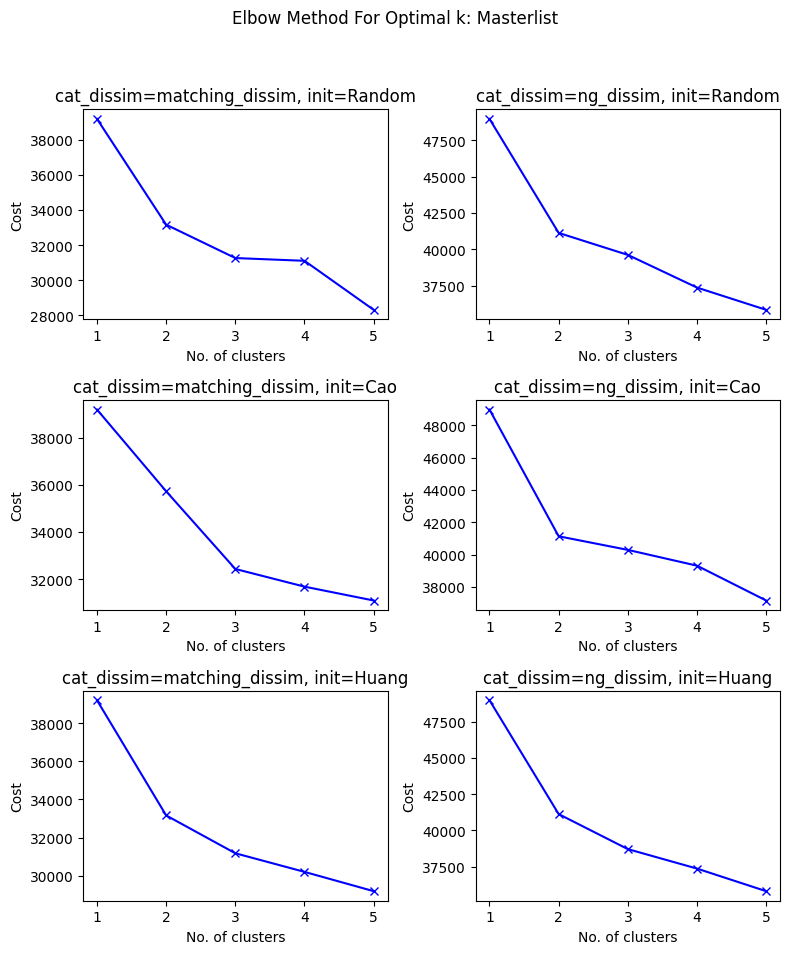

In [37]:
# Elbow curve to find optimal K -> silhoutte plot / elbow curve
# runs 5 seconds for matching dissim / random init
# runs 3 mins for ng dissim / Cao
# in total 80 min

# Define the configuration of KModes parameters
configs = [
    {'cat_dissim': matching_dissim, 'init': 'Random'},
    {'cat_dissim': ng_dissim, 'init': 'Random'},
    {'cat_dissim': matching_dissim, 'init': 'Cao'},
    {'cat_dissim': ng_dissim, 'init': 'Cao'},
    {'cat_dissim': matching_dissim, 'init': 'Huang'},
    {'cat_dissim': ng_dissim, 'init': 'Huang'}
]

# Plot setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
fig.suptitle('Elbow Method For Optimal k: Masterlist')

# Running the configurations
K = range(1, 6)
for ax, config in zip(axes.flatten(), configs):
    cost = []
    for num_clusters in K:
        kmode = KModes(n_clusters=num_clusters, cat_dissim=config['cat_dissim'],
                       init=config['init'], n_init=5, verbose=1)
        kmode.fit_predict(masterlist_with_errors)
        cost.append(kmode.cost_)

    # Plotting each configuration's result
    ax.plot(K, cost, 'bx-')
    ax.set_title(f"cat_dissim={config['cat_dissim'].__name__}, init={config['init']}")
    ax.set_xlabel('No. of clusters')
    ax.set_ylabel('Cost')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('kmodes_elbow_plot_master.jpg', format='jpg')
plt.show()

#### 2.1.2. Golden Record

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 77453.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 77453.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 77453.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 77453.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 77453.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1420, cost: 72466.0
Run 1, iteration: 2/100, moves: 335, cost: 72466.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 210, cost: 64940.0
Init: initializing 

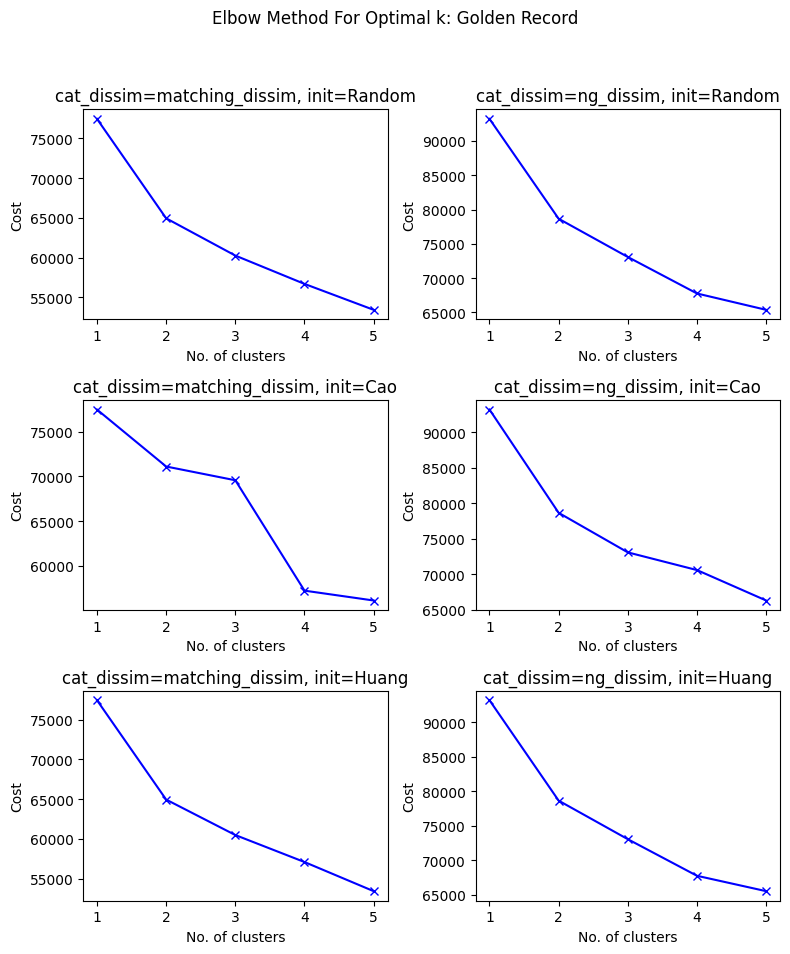

In [38]:
# Elbow curve to find optimal K -> silhoutte plot / elbow curve
# runs 5 seconds for matching dissim / random init
# runs 3 mins for ng dissim / Cao
# in total 80 min

# Define the configuration of KModes parameters
configs = [
    {'cat_dissim': matching_dissim, 'init': 'Random'},
    {'cat_dissim': ng_dissim, 'init': 'Random'},
    {'cat_dissim': matching_dissim, 'init': 'Cao'},
    {'cat_dissim': ng_dissim, 'init': 'Cao'},
    {'cat_dissim': matching_dissim, 'init': 'Huang'},
    {'cat_dissim': ng_dissim, 'init': 'Huang'}
]

# Plot setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
fig.suptitle('Elbow Method For Optimal k: Golden Record')

# Running the configurations
K = range(1, 6)
for ax, config in zip(axes.flatten(), configs):
    cost = []
    for num_clusters in K:
        kmode = KModes(n_clusters=num_clusters, cat_dissim=config['cat_dissim'],
                       init=config['init'], n_init=5, verbose=1)
        kmode.fit_predict(golden_with_errors)
        cost.append(kmode.cost_)

    # Plotting each configuration's result
    ax.plot(K, cost, 'bx-')
    ax.set_title(f"cat_dissim={config['cat_dissim'].__name__}, init={config['init']}")
    ax.set_xlabel('No. of clusters')
    ax.set_ylabel('Cost')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('kmodes_elbow_plot_GR.jpg', format='jpg')
plt.show()

### 2.2. Gap Statistic

In [39]:
def gap_statistic(X, n_refs=10, max_clusters=5):
    """ Gap Statistic implementation for KModes """
    gaps = np.zeros(max_clusters-1)
    for k in range(1, max_clusters):
        kmodes = KModes(n_clusters=k, init='Huang', n_init=5)
        kmodes.fit(X)
        log_wk = np.log(kmodes.cost_)

        # Create reference data
        ref_costs = []
        for i in range(n_refs):
            # Create random reference dataset preserving DataFrame structure and categorical type
            random_data = pd.DataFrame({
                col: np.random.choice(X[col].cat.categories, size=len(X))
                for col in X.columns
            }, index=X.index)
            random_data = random_data.apply(lambda x: x.astype('category'))
            kmodes.fit(random_data)
            ref_costs.append(kmodes.cost_)
        log_wk_refs = np.log(ref_costs).mean()
        gap = log_wk_refs - log_wk
        gaps[k-1] = gap
    return gaps

#### 2.2.1. Masterlist

In [40]:
df = masterlist_with_errors.copy()

# Convert all columns to categorical if not already
df = df.apply(lambda x: x.astype('category'))

# Example of using Gap Statistic to find optimal k
gaps = gap_statistic(df)
optimal_k_gap = np.argmax(gaps) + 1
print("Optimal k found by Gap Statistic:", optimal_k_gap)

Optimal k found by Gap Statistic: 4


#### 2.2.2. Golden Record

In [41]:
df = golden_with_errors.copy()

# Convert all columns to categorical if not already
df = df.apply(lambda x: x.astype('category'))

# Example of using Gap Statistic to find optimal k
gaps = gap_statistic(df)
optimal_k_gap = np.argmax(gaps) + 1
print("Optimal k found by Gap Statistic:", optimal_k_gap)

Optimal k found by Gap Statistic: 4


## 3. ROAD

A Rough Clustering Algorithm for Mining Outliers in Categorical Data (Suri, 2012)

2 types of outliers:
- Type 1: the categorical values describing that object are relatively infrequent
- Type 2: the combination of the categorical values describing that object is relatively infrequent

### 3.1. Type 1: Individual Frequencies

Frequencies for all rows

In [42]:
df1 = []

# Determine the total number of rows in the masterlist DataFrame
num_rows = len(masterlist_with_errors)

# Iterate over the range of row indices
for i in range(num_rows):
    # Obtain data from your custom function (ensure it is defined correctly)
    row_number, total_count, frequency = calculate_frequency(masterlist_with_errors, i)
    # Append the data as a dictionary to df1, make sure to use correct dictionary keys
    df1.append({'Index': i, 'Total Count': total_count, 'Frequency': frequency})

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(df1)

# Optionally, if you want to set 'Index' as the DataFrame index
df.set_index('Index', inplace=True)

Rows with lowest frequencies are Type 1 outliers in the ROAD Algorithm.

Lowest frequencies...

In [43]:
# Row indices with lowest frequencies
sorted_df = df.sort_values(by='Frequency')
df = sorted_df
df.head()

,Total Count,Frequency
Index,,
468,21585,0.232848
6563,22980,0.247896
2493,23368,0.252082
3356,23368,0.252082
9434,27221,0.293646


### 3.2. Type 2: Clustering model
Source: https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py

By using the argument init = "Cao" we use the initialization method from the paper (Cao et al., 2009), as in ROAD

By changing the argument cat_dissim = Ng_dissim, we use the distance measure from paper (Ng et al., 2007), as in ROAD 

Change value for n_clusters in case you want to run for other amount of clusters

In [44]:
# Building the model with n clusters
kmode = KModes(n_clusters=2, cat_dissim=ng_dissim, init = "Cao", n_init = 5, verbose=1)
clusters = kmode.fit_predict(data)

# Get the centroids
centroids = kmode.cluster_centroids_

# Cluster info to rows
# Calculate distances of data points to centroids
distances = np.zeros(len(data))
for j, point in enumerate(data.values):
    min_distance = float('inf')
    for centroid in centroids:
        distance = np.sum(point != centroid)
        if distance < min_distance:
            min_distance = distance
    distances[j] = min_distance

# Insert the predicted cluster values and distances in our original dataset
data.insert(0, "Cluster", clusters, True)
data.insert(1, "Distance to Closest Centroid", distances, True)
Type_2_outliers = data.sort_values(by='Distance to Closest Centroid', ascending=False)
Type_2_outliers

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1262, cost: 78490.02860531573
Run 1, iteration: 2/100, moves: 81, cost: 78657.48769940974
Ng's dissimilarity measure was used to train this model, but now that it is predicting the model will fall back to using simple matching dissimilarity.


,Cluster,Distance to Closest Centroid,System_ID,Material_Number,Sys_GR_Material_Number,Material_GR_Number,GR_System_ID,System_Group_ID,Product_Category_ID,Product_Sub_Category_ID,Business_Line_ID,Brand_ID
1812,0,10.0,T1,A9404604100AD,T1A9404604100AD,A9404604100AD,T1,BPCS,210,210130,02,080
3713,0,10.0,AB,FSA66387.00,ABFSA66387.00,FSA66387.00,AB,FMG,220,220120,02,056
7356,0,10.0,L4,NPM0019,L4NPM0019,NPM0019,L4,BPCS,500,500900,05,080
3432,0,10.0,T1,JMM85523,T1JMM85523,JMM85523,T1,BPCS,500,500900,05,080
8779,0,10.0,AB,ESA22,ABESA22,ESA22,AB,FMG,220,220110,02,056
...,...,...,...,...,...,...,...,...,...,...,...,...
3798,1,3.0,CA,5P89001821,CA5P89001821,5P89001821,CA,Wabco,600,600900,06,074
3803,1,3.0,CA,1090026129,CA000000001090026129,000000001090026129,CA,Wabco,600,600900,06,074
5150,1,3.0,CA,5P08010153,CA5P08010153,5P08010153,CA,Wabco,600,600900,06,074
4152,1,1.0,CA,000000005713310729,CA000000005713310729,000000005713310729,CA,Wabco,600,600900,06,074


## 4. Models research
- Two datasets: Golden record and Masterlist
- Number of error rows: 300; 1000
- Number of error columns: 2; 4

#### 4.1. Data Preparation

In [45]:
# prepare training and test data
def prepare_xtrain_xtest(dataset):

    dataset["label"] = dataset.index > 9999 # all indices for anomalic rows get value True // number to be changed when working with more or less than 10.000 rows of data
    dataset["label"] = dataset["label"].astype(int) # True -> 1 and False -> 0

    dataset = dataset.sample(frac=1)

    X = dataset.drop('label', axis=1)
    y = dataset["label"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, stratify=y, random_state=42)

    return X_train, X_test, y_train, y_test

#### 4.2. Clustering
- Two distance measures: matching dissimilarity and Ng's dissimilarity
- Three initialisation methods: Huang, Cao and Random initialisation


In [109]:
def kmode_clustering(X_train, X_test, y_test, n_clusters, categorical_dissimilarity, initialisation, threshold):

    start_time = time.time()

    X_train_clust = X_train.copy()
    X_test_clust = X_test.copy()

    #############################################
    ###### Training (with X_train_clust) ########
    #############################################

    # Building the model with n clusters
    kmode = KModes(n_clusters=n_clusters, cat_dissim=categorical_dissimilarity, init = initialisation, n_init = 5, verbose=1)
    clusters = kmode.fit_predict(X_train_clust)

    # Get the centroids
    centroids = kmode.cluster_centroids_

    # Calculate distances of data points to centroids to then calculate the threshold
    distances = np.zeros(len(X_train_clust))
    for j, point in enumerate(X_train_clust.values):
        min_distance = float('inf')
        for centroid in centroids:
            distance = np.sum(point != centroid)
            if distance < min_distance:
                min_distance = distance
        distances[j] = min_distance

    # Insert the predicted cluster values and distances in our original dataset
    X_train_clust.insert(1, "Distance to Closest Centroid", distances, True)

    # Calculate the threshold_distance
    top_rows = X_train_clust.nlargest(threshold, 'Distance to Closest Centroid')
    threshold_distance = top_rows.iloc[-1]['Distance to Closest Centroid']

    #############################################
    ######## Testing (with X_test_clust) ########
    #############################################

    # Calculate distances of data points to centroids
    distances = np.zeros(len(X_test_clust))
    for j, point in enumerate(X_test_clust.values):
        min_distance = float('inf')
        for centroid in centroids:
            distance = np.sum(point != centroid)
            if distance < min_distance:
                min_distance = distance
        distances[j] = min_distance    

    X_test_clust.insert(1, "Distance to Closest Centroid", distances, True)
    X_test_clust["prediction"] = np.where(X_test_clust['Distance to Closest Centroid'] >= threshold_distance, 1, 0)
    X_test_clust["label"] = y_test

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
    TP = ((X_test_clust['label'] == 1) & (X_test_clust['prediction'] == 1)).sum()
    TN = ((X_test_clust['label'] == 0) & (X_test_clust['prediction'] == 0)).sum()

    FN = ((X_test_clust['label'] == 1) & (X_test_clust['prediction'] == 0)).sum()
    FP = ((X_test_clust['label'] == 0) & (X_test_clust['prediction'] == 1)).sum()

    # Calculate precision and recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_measure = 2 * (precision * recall) / (precision + recall)

    distances = X_test_clust["Distance to Closest Centroid"]
    scaler = MinMaxScaler()
    anomaly_scores = scaler.fit_transform(distances.values.reshape(-1, 1)).flatten()
    X_test_clust["anomaly_score"] = anomaly_scores
    X_test_clust["anomaly_score"] = X_test_clust["anomaly_score"].round(2)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F-measure:", f_measure)

    print("Clustering", categorical_dissimilarity.__name__, initialisation, count_error_columns, count_error_rows)
    time_to_run = time.time() - start_time
    print(f"Completed in {time_to_run:.2f} seconds")
    
    return categorical_dissimilarity.__name__, initialisation, count_error_columns, count_error_rows, precision, recall, f_measure, TP, TN, FN, FP, time_to_run, X_test_clust

#### 4.3. Frequency

In [110]:
def frequency(data, threshold):

    start_time = time.time()
   
    freq_list = []

    # Determine the total number of rows in the data DataFrame
    num_rows = len(data)

    # Iterate over all rows
    for i in range(num_rows):
        # Obtain frequency data
        row_number, total_count, frequency = calculate_frequency(data, i)
        # Append the data as a dictionary to freq_list
        freq_list.append({'Index': i, 'Total Count': total_count, 'Frequency': frequency})

    # Create DataFrame from the list of dictionaries
    df = pd.DataFrame(freq_list)

    df.set_index('Index', inplace=True)

    df["label"] = df.index > 9999 # all indices for anomalic rows get value True // number to be changed when working with more or less than 10.000 rows of data
    df["label"] = df["label"].astype(int) # True -> 1 and False
    
    # Add the prediction column
    df['prediction'] = 0
    top_rows = df.nsmallest(threshold, 'Frequency')
    df.loc[top_rows.index, 'prediction'] = 1

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
    TP = ((df['label'] == 1) & (df['prediction'] == 1)).sum()
    TN = ((df['label'] == 0) & (df['prediction'] == 0)).sum()
    FN = ((df['label'] == 1) & (df['prediction'] == 0)).sum()
    FP = ((df['label'] == 0) & (df['prediction'] == 1)).sum()
    
    # Calculate precision and recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_measure = 2 * (precision * recall) / (precision + recall)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F-measure:", f_measure)

    print("Frequency", count_error_columns, count_error_rows)
    time_to_run = time.time() - start_time
    print(f"Completed in {time_to_run:.2f} seconds")

    return count_error_columns, count_error_rows, precision, recall, f_measure, TP, TN, FN, FP, time_to_run

#### 4.4. Isolation Forest Tuning

In [ ]:
def isolationforest_tuning(X_train, X_test, y_train, y_test):
    IsolationForest_tuning =[]
    start_time = time.time()
    # copy the dfs
    X_train_iso = X_train.copy()
    X_test_iso = X_test.copy()
    y_train_iso = y_train.copy()   
    # Split training data into taining and tuning data
    X_train_iso, X_tuning_iso, y_train_iso, y_tuning_iso = train_test_split(X_train_iso, y_train_iso, test_size= 0.1, stratify=y_train_iso, random_state=42)
    def encode_categorical_columns(df):
        for col in df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    # Apply encoding to each dataset, because Isolation Forest can only run on numeric data
    encode_categorical_columns(X_train_iso)
    encode_categorical_columns(X_tuning_iso)
    encode_categorical_columns(X_test_iso)

    for n_estimators in [50, 100, 200]:
        for contamination in [0.1, 0.2, 0.3, 0.4]:
            for max_features in [2, 3, 5, 6, 7, 8, 9]:   
                for bootstrap in [True, False]:  
                    for n_jobs in [5, 10, 20, 30]:  
                        iso_forest = IsolationForest(random_state=42, 
                                          n_estimators = n_estimators,
                                          contamination = contamination,
                                          max_features = max_features,
                                          bootstrap = bootstrap,
                                          n_jobs = n_jobs)

                        iso_forest.fit(X_train_iso, y_train_iso)

                        # Predict anomalies (-1 for outliers and 1 for inliers)
                        is_anomaly = iso_forest.predict(X_tuning_iso)

                        X_tuning_iso1 = X_tuning_iso.copy() 
                        y_tuning_iso1 = y_tuning_iso.copy() 

                        # Add anomaly labels to the dataset for visualization
                        X_tuning_iso1['prediction'] = is_anomaly
                        X_tuning_iso1['prediction'] = X_tuning_iso1['prediction'].replace({1: 0, -1: 1})
                        X_tuning_iso1["label"] = y_tuning_iso1
                        # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
                        TP = ((X_tuning_iso1['label'] == 1) & (X_tuning_iso1['prediction'] == 1)).sum()
                        TN = ((X_tuning_iso1['label'] == 0) & (X_tuning_iso1['prediction'] == 0)).sum()
                        FN = ((X_tuning_iso1['label'] == 1) & (X_tuning_iso1['prediction'] == 0)).sum()
                        FP = ((X_tuning_iso1['label'] == 0) & (X_tuning_iso1['prediction'] == 1)).sum()
                        # Calculate precision and recall
                        precision = TP / (TP + FP)
                        recall = TP / (TP + FN)
                        f_measure = 2 * (precision * recall) / (precision + recall)

                        precision = precision.round(3)
                        recall = recall.round(3)
                        f_measure = f_measure.round(3)
                        IsolationForest_results1.append([n_estimators,contamination,max_features, bootstrap, n_jobs, precision, recall, f_measure])

    IsolationForest_tuning = pd.DataFrame(IsolationForest_results1, 
                      columns=["n_estimators","contamination","max_features", "bootstrap", "n_jobs", "precision", "recall", "f_measure"])  
    IsolationForest_tuning["count_error_rows"]  = count_error_rows 
    IsolationForest_tuning["count_error_columns"]  = count_error_columns    
    return IsolationForest_tuning

#### 4.5. Isolation Forest

In [183]:
def isolationforest_testing(X_train, X_test, y_train, y_test):
    start_time = time.time()
    # copy the dfs
    X_train_iso2 = X_train.copy()
    X_test_iso2 = X_test.copy()
    y_train_iso2 = y_train.copy()   
    def encode_categorical_columns(df):
        for col in df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    # Apply encoding to each dataset, because Isolation Forest can only run on numeric data
    encode_categorical_columns(X_train_iso2)
    encode_categorical_columns(X_test_iso2)
    iso_forest = IsolationForest(random_state=42, 
                  n_estimators = 50,
                  contamination = 0.1,
                  max_features = 7,
                  bootstrap = False,
                  n_jobs = 5)
    iso_forest.fit(X_train_iso2, y_train_iso2)
    # Predict anomalies (-1 for outliers and 1 for inliers)
    is_anomaly = iso_forest.predict(X_test_iso2)
    X_test_iso1 = X_test_iso2.copy() 
    y_test_iso1 = y_test.copy() 
    # Add anomaly labels to the dataset for visualization
    X_test_iso1['prediction'] = is_anomaly
    X_test_iso1['prediction'] = X_test_iso1['prediction'].replace({1: 0, -1: 1})
    X_test_iso1["label"] = y_test
    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
    TP = ((X_test_iso1['label'] == 1) & (X_test_iso1['prediction'] == 1)).sum()
    TN = ((X_test_iso1['label'] == 0) & (X_test_iso1['prediction'] == 0)).sum()
    FN = ((X_test_iso1['label'] == 1) & (X_test_iso1['prediction'] == 0)).sum()
    FP = ((X_test_iso1['label'] == 0) & (X_test_iso1['prediction'] == 1)).sum()
    # Calculate precision and recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_measure = 2 * (precision * recall) / (precision + recall)
    precision = precision.round(3)
    recall = recall.round(3)
    f_measure = f_measure.round(3)
    time_to_run = time.time() - start_time
    print(f"Completed in {time_to_run:.2f} seconds")
    return count_error_columns, count_error_rows, precision, recall, f_measure, TP, TN, FN, FP, time_to_run

#### 4.6. Visualize Clustering

In [112]:
def visualize_clustering_with_dimension_reduction(X_train, y_train):
    start_time = time.time()

    # One-Hot Encoding
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train_encoded = encoder.fit_transform(X_train)

    # PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_encoded.toarray())  # PCA expects a dense matrix

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_train_tsne = tsne.fit_transform(X_train_encoded.toarray())

    # Colors for plotting based on y_train labels (outliers)
    colors = np.where(y_train == 1, 'red', 'green')  # Assume y_train == 1 indicates outliers

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{datasetname} ; Outlier rows: {count_error_rows} ; Anomalous columns {count_error_columns}", fontsize=16)

    # PCA plot
    ax[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors, alpha=0.5)
    ax[0].set_title('PCA')
    ax[0].set_xlabel('PCA dimension 1')
    ax[0].set_ylabel('PCA dimension 2')

    # t-SNE plot
    ax[1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors, alpha=0.5)
    ax[1].set_title('t-SNE')
    ax[1].set_xlabel('t-SNE dimension 1')
    ax[1].set_ylabel('t-SNE dimension 2')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the global title
    plt.savefig(f'K-modes Clustering Visualization {datasetname} {count_error_rows} {count_error_columns}.jpg', format='jpg')
    plt.show()

    duration = time.time() - start_time
    print(f"Completed K-modes Clustering Visualization in {duration:.2f} seconds")

## 5. Results

### 5.1. Masterlist

In [204]:
Clustering_results = []
Frequency_results = []
IsolationForest_tuning_all = pd.DataFrame()
IsolationForest_results = []
datasetname = "Masterlist"

for count_error_rows in [300,1000]: # loop on number of outlier rows

    start_time = time.time()
    data = masterlist_10000.copy()
    data = shuffle_last_n_rows(count_error_rows)
    time_to_run = time.time() - start_time
    print(f"Shuffling rows completed in {time_to_run:.2f} seconds")

    for count_error_columns in [2,4]: # loop on number of anomalous columns
        
        start_time = time.time()
        change_anomaly_rows(count_error_columns, count_error_rows, masterlist) 
        time_to_run = time.time() - start_time
        print(f"Added outliers/codes completed in {time_to_run:.2f} seconds")

        X_train, X_test, y_train, y_test = prepare_xtrain_xtest(data)

        Clustering_results.append(kmode_clustering(X_train, X_test, y_test, 2, matching_dissim, "Huang", count_error_rows))
        Clustering_results.append(kmode_clustering(X_train, X_test, y_test, 3, matching_dissim, "Cao", count_error_rows))
        Clustering_results.append(kmode_clustering(X_train, X_test, y_test, 2, matching_dissim, "Random", count_error_rows))
        Clustering_results.append(kmode_clustering(X_train, X_test, y_test, 2, ng_dissim, "Huang", count_error_rows))
        Clustering_results.append(kmode_clustering(X_train, X_test, y_test, 2, ng_dissim, "Cao", count_error_rows))
        Clustering_results.append(kmode_clustering(X_train, X_test, y_test, 2, ng_dissim, "Random", count_error_rows))
        Frequency_results.append(frequency(data, count_error_rows))
        IsolationForest_tuning_all = pd.concat([IsolationForest_tuning_all, isolationforest_tuning(X_train, X_test, y_train, y_test)])
        IsolationForest_results.append(isolationforest_testing(X_train, X_test, y_train, y_test))
        visualize_clustering_with_dimension_reduction(X_train, y_train)

/var/folders/t0/8mjjl9953sq6_h0_9dyz0jk00000gn/T/ipykernel_74526/813838698.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return data.append(shuffled_last_n_rows, ignore_index=True)


Shuffling rows completed in 0.17 seconds
Added outliers/codes completed in 1.00 seconds
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1737, cost: 29754.0
Run 1, iteration: 2/100, moves: 131, cost: 29754.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1697, cost: 29754.0
Run 2, iteration: 2/100, moves: 154, cost: 29754.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 836, cost: 32547.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3042, cost: 30681.0
Run 4, iteration: 2/100, moves: 40, cost: 30681.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 768, cost: 31348.0
Best run was number 1
Precision: 0.0273224043715847
Recall: 0.16666666666666666
F-measure: 0.046948356

#### 5.1.1. Tabular results

In [120]:
Clus_results = pd.DataFrame([row[:12] for row in Clustering_results], 
                  columns=['Dissimilarity measure','Initialisation method', 'Number of anomalic columns', 
                           'Number of anomalic rows', 'Precision', 'Recall','F-measure',
                           'TP', 'TN', 'FN', 'FP','Running time'])
for col in ["Precision", "Recall", "F-measure", "Running time"]:
    Clus_results[col] = Clus_results[col].round(3)
Clus_results

,Dissimilarity measure,Initialisation method,Number of anomalic columns,Number of anomalic rows,Precision,Recall,F-measure,TP,TN,FN,FP,Running time
0,matching_dissim,Huang,2,300,0.045,0.30,0.079,9,810,21,190,4.059
1,matching_dissim,Cao,2,300,0.041,0.30,0.072,9,790,21,210,1.651
2,matching_dissim,Random,2,300,0.045,0.30,0.079,9,810,21,190,1.614
3,ng_dissim,Huang,2,300,0.056,0.50,0.100,15,746,15,254,143.199
4,ng_dissim,Cao,2,300,0.056,0.50,0.100,15,746,15,254,27.848
5,ng_dissim,Random,2,300,0.056,0.50,0.100,15,746,15,254,151.239
6,matching_dissim,Huang,4,300,0.140,1.00,0.246,30,816,0,184,5.404
7,matching_dissim,Cao,4,300,0.131,1.00,0.232,30,801,0,199,1.666
8,matching_dissim,Random,4,300,0.140,1.00,0.246,30,816,0,184,2.096
9,ng_dissim,Huang,4,300,0.112,1.00,0.202,30,763,0,237,127.972


In [121]:
Freq_results = pd.DataFrame(Frequency_results, columns=['Number of anomalic columns', 'Number of anomalic rows', 'Precision', 'Recall','F-measure','TP', 'TN', 'FN', 'FP','Running time'])
for col in ["Precision", "Recall", "F-measure", "Running time"]:
    Freq_results[col] = Freq_results[col].round(3)
Freq_results

,Number of anomalic columns,Number of anomalic rows,Precision,Recall,F-measure,TP,TN,FN,FP,Running time
0,2,300,0.150,0.150,0.150,45,9745,255,255,18.196
1,4,300,0.153,0.153,0.153,46,9746,254,254,18.492
2,2,1000,0.494,0.494,0.494,494,9494,506,506,20.152
3,4,1000,0.553,0.553,0.553,553,9553,447,447,20.094


In [186]:
IsoFor_results = pd.DataFrame(IsolationForest_results, columns=['Number of anomalic columns', 'Number of anomalic rows','Precision', 'Recall','F-measure','TP', 'TN', 'FN', 'FP','Running time'])
for col in ["Precision", "Recall", "F-measure", "Running time"]:
    IsoFor_results[col] = IsoFor_results[col].round(3)
IsoFor_results

,Number of anomalic columns,Number of anomalic rows,Precision,Recall,F-measure,TP,TN,FN,FP,Running time
0,2,300,0.057,0.200,0.089,6,901,24,99,0.137
1,4,300,0.016,0.067,0.026,2,878,28,122,0.133
2,2,1000,0.112,0.140,0.124,14,889,86,111,0.135
3,4,1000,0.142,0.150,0.146,15,909,85,91,0.133


#### 5.1.2. Plots

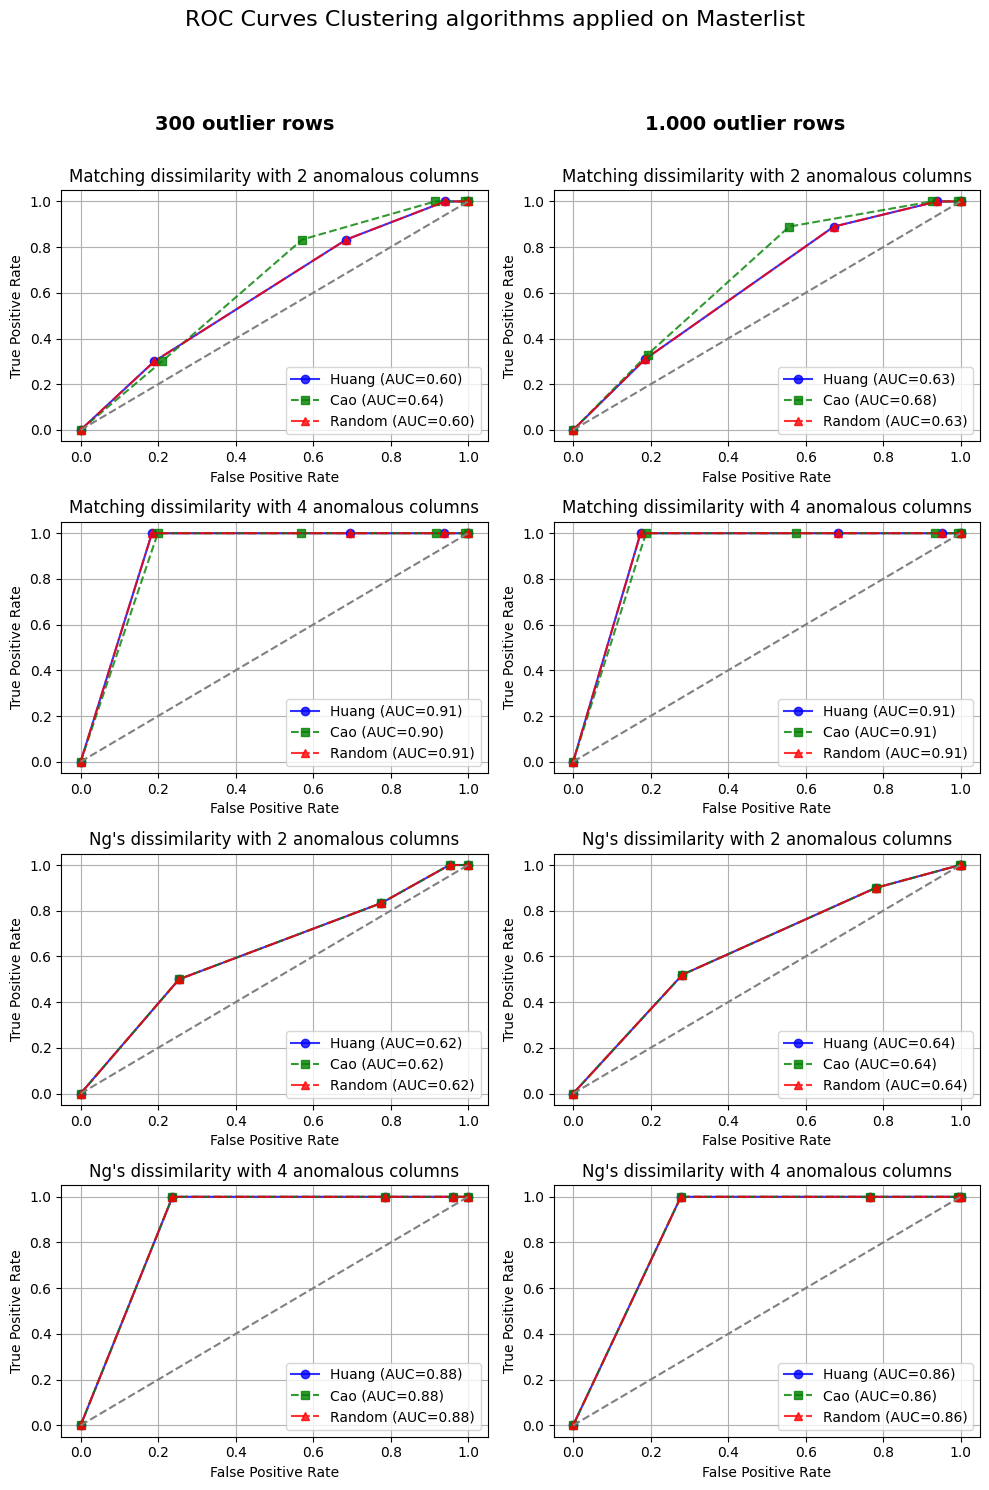

In [206]:
def get_cluster_results(i):
    # data fetching
    return Clustering_results[i][12]['label'], Clustering_results[i][12]['anomaly_score']

fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # 4 rows, 2 columns
fig.suptitle("ROC Curves Clustering algorithms applied on Masterlist", fontsize=16, y=1.02)

titles = [
    "Matching dissimilarity with 2 anomalous columns",
    "Matching dissimilarity with 2 anomalous columns",
    "Matching dissimilarity with 4 anomalous columns",
    "Matching dissimilarity with 4 anomalous columns",
    "Ng's dissimilarity with 2 anomalous columns",
    "Ng's dissimilarity with 2 anomalous columns",
    "Ng's dissimilarity with 4 anomalous columns",
    "Ng's dissimilarity with 4 anomalous columns"
]

cluster_groups = [
    [0, 1, 2],
    [12, 13, 14],
    [6, 7, 8],
    [18, 19, 20],
    [3, 4, 5],
    [15, 16, 17],
    [9, 10, 11],
    [21, 22, 23]
]

# Labels mapping based on cluster index
cluster_labels = {
    0: "Huang", 1: "Cao", 2: "Random",
    3: "Huang", 4: "Cao", 5: "Random",
    6: "Huang", 7: "Cao", 8: "Random",
    9: "Huang", 10: "Cao", 11: "Random",
    12: "Huang", 13: "Cao", 14: "Random",
    15: "Huang", 16: "Cao", 17: "Random",
    18: "Huang", 19: "Cao", 20: "Random",
    21: "Huang", 22: "Cao", 23: "Random"
}

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd', 'x', '*']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for idx, clusters in enumerate(cluster_groups):
    row = idx // 2  # Determine row index (0 to 3)
    col = idx % 2   # Determine column index (0 or 1)
    
    for cluster_idx, cluster in enumerate(clusters):
        labels, scores = get_cluster_results(cluster)
        fpr, tpr, _ = roc_curve(labels, scores)
        auc = roc_auc_score(labels, scores)
        
        # Format label with AUC
        label = f'{cluster_labels[cluster]} (AUC={auc:.2f})'
        axes[row, col].plot(fpr, tpr, label=label, linestyle=line_styles[cluster_idx % len(line_styles)],
                            marker=markers[cluster_idx % len(markers)], color=colors[cluster_idx % len(colors)], alpha=0.8)
        
    axes[row, col].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[row, col].set_xlabel('False Positive Rate')
    axes[row, col].set_ylabel('True Positive Rate')
    axes[row, col].set_title(titles[idx])
    axes[row, col].legend(loc='lower right')
    axes[row, col].grid(True)

fig.text(0.25, 0.95, '300 outlier rows', ha='center', va='top', fontsize=14, fontweight='bold')
fig.text(0.75, 0.95, '1.000 outlier rows', ha='center', va='top', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(top=0.9)
plt.savefig('ROC_Clustering_Masterlist.jpg', format='jpg')
plt.show()

### 5.2. Golden Record

In [187]:
Clustering_results_GR = []
Frequency_results_GR = []
IsolationForest_results_GR = []
datasetname = "Golden Record"
IsolationForest_tuning_all_GR = pd.DataFrame()

for count_error_rows in [300,1000]: # loop on number of outlier rows

    start_time = time.time()
    data = golden_10000.copy()
    data = shuffle_last_n_rows(count_error_rows)
    time_to_run = time.time() - start_time
    print(f"Completed in {time_to_run:.2f} seconds")

    for count_error_columns in [4,6]: # loop on number of anomalous columns
        
        start_time = time.time()
        change_anomaly_rows(count_error_columns, count_error_rows, golden) 
        time_to_run = time.time() - start_time
        print(f"Completed in {time_to_run:.2f} seconds")

        X_train, X_test, y_train, y_test = prepare_xtrain_xtest(data)

        Clustering_results_GR.append(kmode_clustering(X_train, X_test, y_test, 2, matching_dissim, "Huang", count_error_rows))
        Clustering_results_GR.append(kmode_clustering(X_train, X_test, y_test, 2, matching_dissim, "Cao", count_error_rows))
        Clustering_results_GR.append(kmode_clustering(X_train, X_test, y_test, 2, matching_dissim, "Random", count_error_rows))
        Clustering_results_GR.append(kmode_clustering(X_train, X_test, y_test, 2, ng_dissim, "Huang", count_error_rows))
        Clustering_results_GR.append(kmode_clustering(X_train, X_test, y_test, 2, ng_dissim, "Cao", count_error_rows))
        Clustering_results_GR.append(kmode_clustering(X_train, X_test, y_test, 2, ng_dissim, "Random", count_error_rows))
        Frequency_results_GR.append(frequency(data, count_error_rows))
        IsolationForest_tuning_all_GR = pd.concat([IsolationForest_tuning_all_GR, isolationforest_tuning(X_train, X_test, y_train, y_test)])
        IsolationForest_results_GR.append(isolationforest_testing(X_train, X_test, y_train, y_test))
        visualize_clustering_with_dimension_reduction(X_train, y_train)

/var/folders/t0/8mjjl9953sq6_h0_9dyz0jk00000gn/T/ipykernel_74526/813838698.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return data.append(shuffled_last_n_rows, ignore_index=True)


Completed in 0.00 seconds
Completed in 84.67 seconds


/Users/z0176164/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Completed in 0.20 seconds
Completed in 119.84 seconds
Completed in 0.16 seconds
Completed in 0.00 seconds


/Users/z0176164/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/var/folders/t0/8mjjl9953sq6_h0_9dyz0jk00000gn/T/ipykernel_74526/813838698.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return data.append(shuffled_last_n_rows, ignore_index=True)


Completed in 274.85 seconds


/Users/z0176164/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Completed in 0.18 seconds
Completed in 390.59 seconds
Completed in 0.18 seconds


/Users/z0176164/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


#### 5.2.1. Tabular results

In [125]:
Clus_results_GR = pd.DataFrame([row[:12] for row in Clustering_results_GR], 
                  columns=['Dissimilarity measure','Initialisation method', 'Number of anomalic columns', 
                           'Number of anomalic rows', 'Precision', 'Recall','F-measure',
                           'TP', 'TN', 'FN', 'FP','Running time'])
for col in ["Precision", "Recall", "F-measure", "Running time"]:
    Clus_results_GR[col] = Clus_results_GR[col].round(3)
Clus_results_GR

,Dissimilarity measure,Initialisation method,Number of anomalic columns,Number of anomalic rows,Precision,Recall,F-measure,TP,TN,FN,FP,Running time
0,matching_dissim,Huang,4,300,0.043,0.233,0.072,7,843,23,157,5.148
1,matching_dissim,Cao,4,300,0.025,0.033,0.029,1,961,29,39,1.288
2,matching_dissim,Random,4,300,0.043,0.233,0.072,7,843,23,157,1.970
3,ng_dissim,Huang,4,300,0.043,0.233,0.072,7,843,23,157,1323.228
4,ng_dissim,Cao,4,300,0.043,0.233,0.072,7,843,23,157,9.739
5,ng_dissim,Random,4,300,0.043,0.233,0.072,7,843,23,157,54.888
6,matching_dissim,Huang,6,300,0.125,0.800,0.216,24,832,6,168,5.056
7,matching_dissim,Cao,6,300,0.067,0.100,0.080,3,958,27,42,1.280
8,matching_dissim,Random,6,300,0.125,0.800,0.216,24,832,6,168,1.680
9,ng_dissim,Huang,6,300,0.125,0.800,0.216,24,832,6,168,43.531


In [126]:
Freq_results_GR = pd.DataFrame(Frequency_results_GR, columns=['Number of anomalic columns', 'Number of anomalic rows', 'Precision', 'Recall','F-measure','TP', 'TN', 'FN', 'FP','Running time'])
for col in ["Precision", "Recall", "F-measure", "Running time"]:
    Freq_results_GR[col] = Freq_results_GR[col].round(3)
Freq_results_GR

,Number of anomalic columns,Number of anomalic rows,Precision,Recall,F-measure,TP,TN,FN,FP,Running time
0,4,300,0.590,0.590,0.590,177,9877,123,123,38.421
1,6,300,0.983,0.983,0.983,295,9995,5,5,38.856
2,4,1000,0.541,0.541,0.541,541,9541,459,459,44.365
3,6,1000,0.980,0.980,0.980,980,9980,20,20,44.219


In [190]:
IsoFor_results_GR = pd.DataFrame(IsolationForest_results_GR, columns=['Number of anomalic columns', 'Number of anomalic rows','Precision', 'Recall','F-measure','TP', 'TN', 'FN', 'FP','Running time'])
for col in ["Precision", "Recall", "F-measure", "Running time"]:
    IsoFor_results_GR[col] = IsoFor_results_GR[col].round(3)
IsoFor_results_GR

,Number of anomalic columns,Number of anomalic rows,Precision,Recall,F-measure,TP,TN,FN,FP,Running time
0,4,300,0.029,0.90,0.056,27,94,3,906,0.202
1,6,300,0.029,1.00,0.057,30,0,0,1000,0.162
2,4,1000,0.107,0.73,0.186,73,389,27,611,0.178
3,6,1000,0.091,1.00,0.167,100,0,0,1000,0.179


#### 5.2.2. Plots

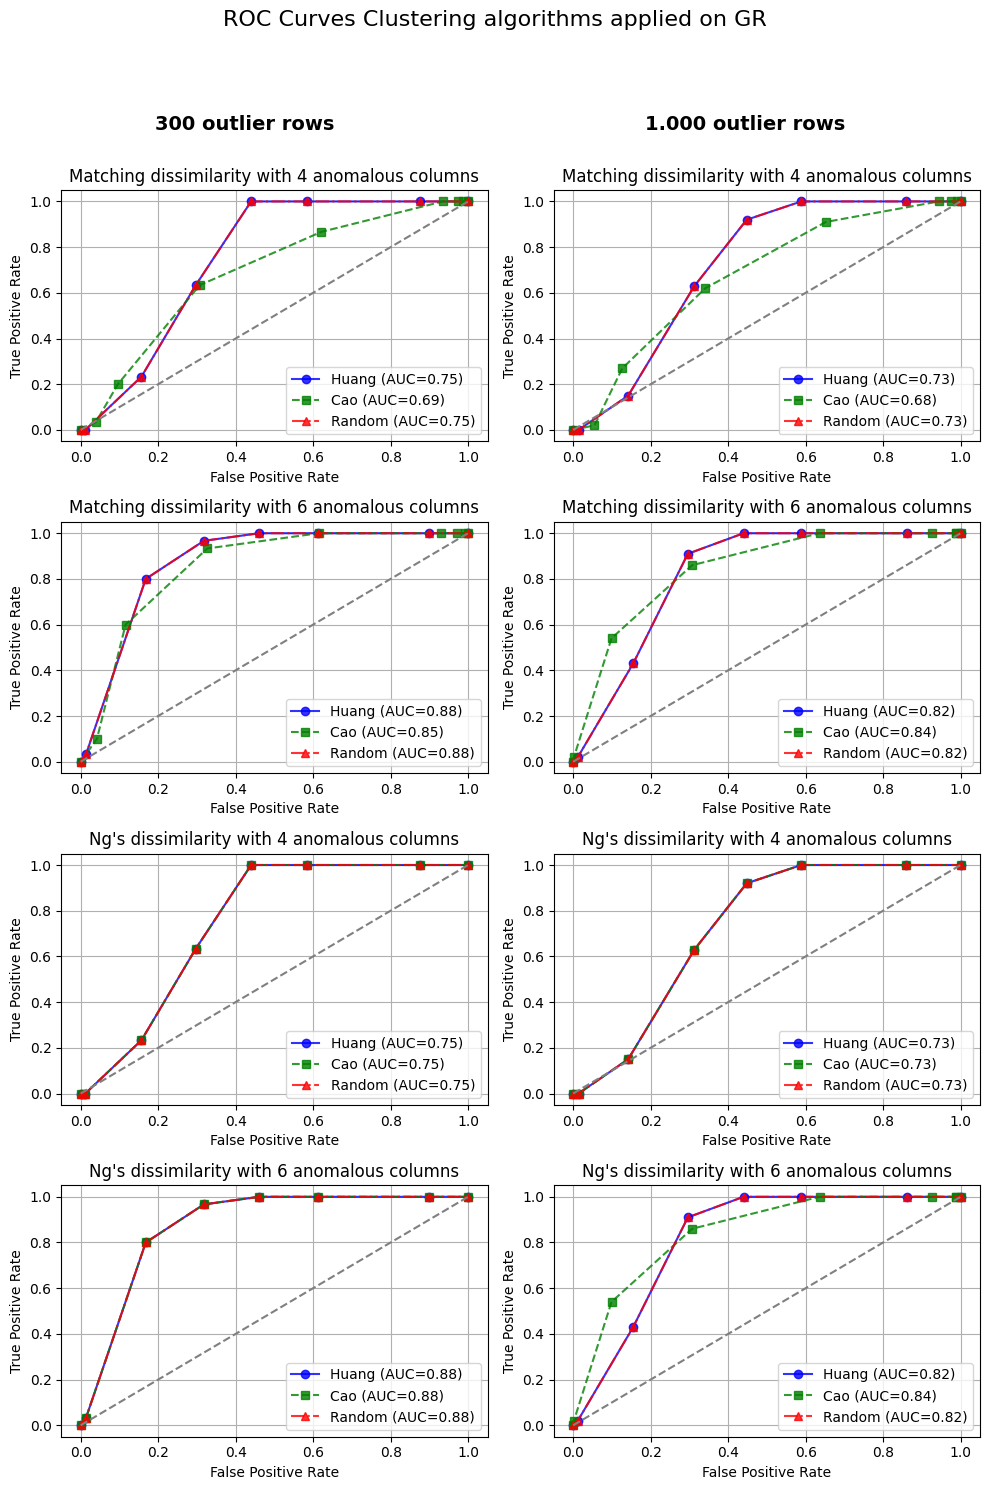

In [128]:
# Example function to get data from Clustering_results
def get_cluster_results(i):
    # data fetching
    return Clustering_results_GR[i][12]['label'], Clustering_results_GR[i][12]['anomaly_score']

fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # 4 rows, 2 columns
fig.suptitle("ROC Curves Clustering algorithms applied on GR", fontsize=16, y=1.02)

titles = [
    "Matching dissimilarity with 4 anomalous columns",
    "Matching dissimilarity with 4 anomalous columns",
    "Matching dissimilarity with 6 anomalous columns",
    "Matching dissimilarity with 6 anomalous columns",
    "Ng's dissimilarity with 4 anomalous columns",
    "Ng's dissimilarity with 4 anomalous columns",
    "Ng's dissimilarity with 6 anomalous columns",
    "Ng's dissimilarity with 6 anomalous columns"
]

cluster_groups = [
    [0, 1, 2],
    [12, 13, 14],
    [6, 7, 8],
    [18, 19, 20],
    [3, 4, 5],
    [15, 16, 17],
    [9, 10, 11],
    [21, 22, 23]
]

# Labels mapping based on cluster index
cluster_labels = {
    0: "Huang", 1: "Cao", 2: "Random",
    3: "Huang", 4: "Cao", 5: "Random",
    6: "Huang", 7: "Cao", 8: "Random",
    9: "Huang", 10: "Cao", 11: "Random",
    12: "Huang", 13: "Cao", 14: "Random",
    15: "Huang", 16: "Cao", 17: "Random",
    18: "Huang", 19: "Cao", 20: "Random",
    21: "Huang", 22: "Cao", 23: "Random"
}

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd', 'x', '*']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for idx, clusters in enumerate(cluster_groups):
    row = idx // 2  # Determine row index (0 to 3)
    col = idx % 2   # Determine column index (0 or 1)
    
    for cluster_idx, cluster in enumerate(clusters):
        labels, scores = get_cluster_results(cluster)
        fpr, tpr, _ = roc_curve(labels, scores)
        auc = roc_auc_score(labels, scores)
        
        # Format label with AUC
        label = f'{cluster_labels[cluster]} (AUC={auc:.2f})'
        axes[row, col].plot(fpr, tpr, label=label, linestyle=line_styles[cluster_idx % len(line_styles)],
                            marker=markers[cluster_idx % len(markers)], color=colors[cluster_idx % len(colors)], alpha=0.8)
        
    axes[row, col].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[row, col].set_xlabel('False Positive Rate')
    axes[row, col].set_ylabel('True Positive Rate')
    axes[row, col].set_title(titles[idx])
    axes[row, col].legend(loc='lower right')
    axes[row, col].grid(True)

fig.text(0.25, 0.95, '300 outlier rows', ha='center', va='top', fontsize=14, fontweight='bold')
fig.text(0.75, 0.95, '1.000 outlier rows', ha='center', va='top', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(top=0.9)
plt.savefig('ROC_Clustering_GR.jpg', format='jpg')
plt.show()

### 5.3. Export results

In [191]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Tabular_Master_Thesis_results.xlsx', engine='xlsxwriter')

# Write each dataframe to a different sheet.
Clus_results.to_excel(writer, sheet_name='Clus_ML', index=False)
Freq_results.to_excel(writer, sheet_name='Freq_ML', index=False)
IsoFor_results.to_excel(writer, sheet_name='IsoFor_ML', index=False)
Clus_results_GR.to_excel(writer, sheet_name='Clus_GR', index=False)
Freq_results_GR.to_excel(writer, sheet_name='Freq_GR', index=False)
IsoFor_results_GR.to_excel(writer, sheet_name='IsoFor_GR', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Optionally, close the writer explicitly if not using 'with' context manager
writer.close()

/var/folders/t0/8mjjl9953sq6_h0_9dyz0jk00000gn/T/ipykernel_74526/1752959043.py:13: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
/Users/z0176164/Library/Python/3.9/lib/python/site-packages/xlsxwriter/workbook.py:369: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
